# Dask

*[Dask](http://dask.pydata.org) is a flexible parallel computing library for analytic computing* written in Python. Dask is similar to Spark, by lazily constructing directed acyclic graph (DAG) of tasks and splitting large datasets into small portions called partitions. See the below image from [Dask's web page](http://dask.pydata.org) for illustration. 

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png) 

It has three main interfaces:

* [Array](http://dask.pydata.org/en/latest/array.html), which works like [NumPy](http://www.numpy.org/) arrays;
* [Bag](http://dask.pydata.org/en/latest/bag.html), which is similar to RDD interface in Spark;
* [DataFrame](http://dask.pydata.org/en/latest/dataframe.html), which works like [Pandas](https://pandas.pydata.org/) DataFrame.

While it can work on a [distributed cluster](http://dask.pydata.org/en/latest/distributed.html), Dask works also very well on a single cpu machine. 

# Dask DataFrames

Dask dataframes look and feel (mostly) like Pandas dataframes but they run on the same infrastructure that powers dask.delayed.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

In this notebook, we will extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is taken from [here](http://stat-computing.org/dataexpo/2009/the-data.html). This should only take a few seconds to run.

We will use `dask.dataframe` construct our computations for us.  The `dask.dataframe.read_csv` function can take a globstring like `"data/nycflights/*.csv"` and build parallel computations on all of our data at once.

### Prep the Data

In [1]:
import pandas as pd
pd.set_option("max.rows", 10)

In [2]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_flight():
    flightdir = os.path.join('data', 'nycflights')
    if not os.path.exists(flightdir):
       print("Extracting flight data")
       tar_path = os.path.join('data', 'nycflights.tar.gz')
       with tarfile.open(tar_path, mode='r:gz') as flights:
          flights.extractall('data/')
            
extract_flight() # this function call will extract 10 csv files in data/nycflights

Extracting flight data


### Load Data from CSVs in Dask Dataframes

In [3]:
import os
filename = os.path.join('data', 'nycflights', '*.csv')
filename

'data/nycflights/*.csv'

In [4]:
import dask
import dask.dataframe as dd

df = dd.read_csv(filename,
                 parse_dates={'Date': [0, 1, 2]})

Let's take a look to the dataframe

In [5]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
# Get the first 5 rows
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [7]:
# Get the last 5 rows
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N539UA'",)

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### What just happened?

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

In [8]:
df.dtypes

Date          datetime64[ns]
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
                   ...      
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
Length: 21, dtype: object

In [9]:
df = dd.read_csv(filename,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [10]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


Let's take a look at one more example to fix ideas.

In [11]:
len(df)

2611892

### Why df is ten times longer ?

- Dask investigated the input path and found that there are ten matching files. 
- A set of jobs was intelligently created for each chunk - one per original CSV file in this case. 
- Each file was loaded into a pandas dataframe, had `len()` applied to it.
- The subtotals were combined to give you the final grant total.

## Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column.  With `dask.delayed` we could create this computation as follows:

```python
maxes = []
for fn in filenames:
    df = dask.delayed(pd.read_csv)(fn)
    maxes.append(df.DepDelay.max())
    
final_max = dask.delayed(max)(maxes)
final_max.compute()
```

Now we just use the normal Pandas syntax as follows:

In [12]:
%time df.DepDelay.max().compute()

CPU times: user 14.4 s, sys: 1.79 s, total: 16.2 s
Wall time: 7.27 s


1435.0

This writes the delayed computation for us and then runs it. Recall that the delayed computation is a dask graph made of up of key-value pairs.

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

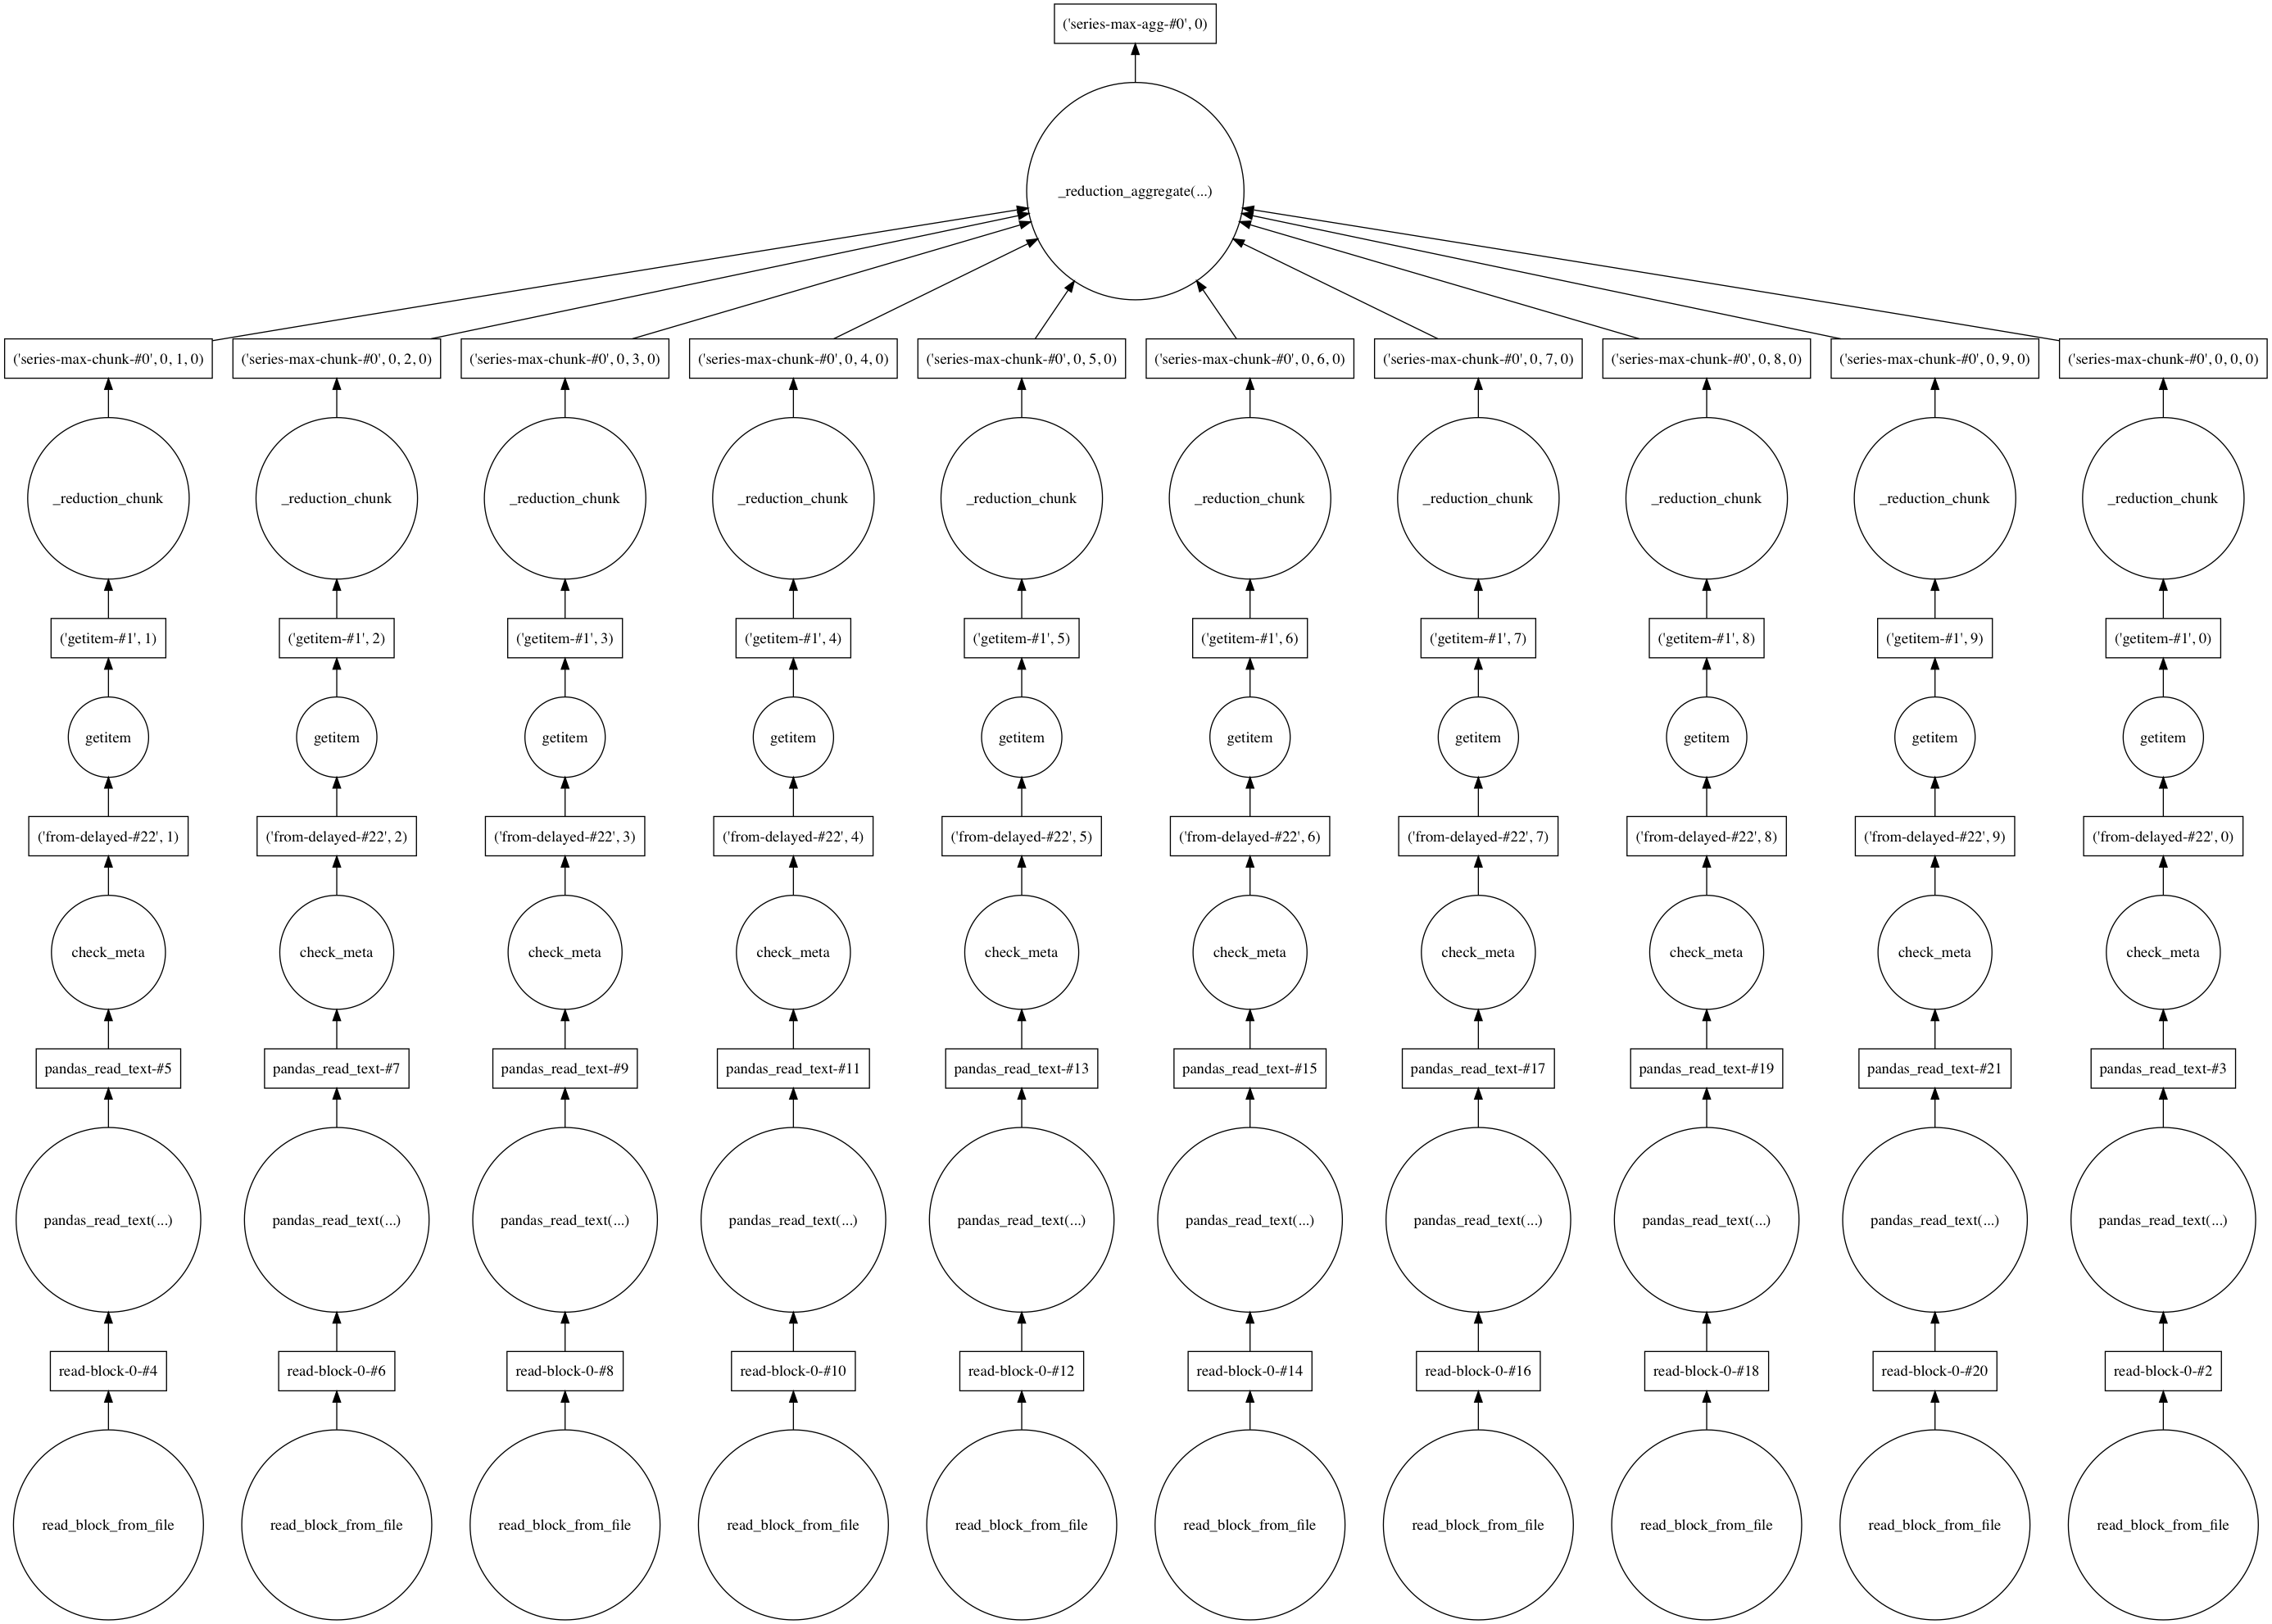

In [13]:
df.DepDelay.max().visualize()

## Exercises

If you are already familiar with the Pandas API then know how to use `dask.dataframe`.  There are a couple of small changes.

As noted above, computations on dask `DataFrame` objects don't perform work, instead they build up a dask graph.  We can evaluate this dask graph at any time using the `.compute()` method.

In [14]:
result = df.DepDelay.mean()  # create the tasks graph

In [15]:
result.compute()           # perform actual computation

9.2066025413219652

If you don't remember how to use pandas.  Please read [pandas documentation](http://pandas.pydata.org/).

### 1.) Use the `head()` method to get the first ten rows

In [16]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


### 2.) How many rows are in our dataset?

In [17]:
len(df)

2611892

### 3.)  Use selections `df[...]` to find how many positive (late) and negative (early) departure times there are

In [21]:
%%time
len(df[ df.DepDelay > 0])

CPU times: user 14.2 s, sys: 1.76 s, total: 16 s
Wall time: 6.94 s


1187146

In [23]:
%%time
len(df[df.DepDelay < 0])

CPU times: user 14.7 s, sys: 1.86 s, total: 16.6 s
Wall time: 7.21 s


840942

In [24]:
%%time
import dask

early = df[df.DepDelay < 0].size
late = df[df.DepDelay > 0].size

early_res, late_res = dask.compute(early, late)

CPU times: user 14.3 s, sys: 1.83 s, total: 16.1 s
Wall time: 6.94 s


### 4.) In total, how many non-cancelled flights were taken?

hint: To invert a boolean pandas Series s, use ~s.

In [34]:
s = pd.Series([True, True, False, True])
~s

0    False
1    False
2     True
3    False
dtype: bool

In [26]:
len(df[~df.Cancelled])

2540961

Divisions and the Index
---------------------------

The Pandas index associates a value to each record/row of your data.  Operations that align with the index, like `loc` can be a bit faster as a result.

In `dask.dataframe` this index becomes even more important.  Recall that one dask `DataFrame` consists of several Pandas `DataFrame`s.  These dataframes are separated along the index by value.  For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas `DataFrames` on demand.

Partitioning your data can greatly improve efficiency.  Operations like `loc`, `groupby`, and `merge/join` along the index are *much more efficient* than operations along other columns.  You can see how your dataset is partitioned with the `.divisions` attribute.  Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default.  In these cases the values for `.divisions` will be `None.`

In [27]:
df = dd.read_csv(filename,
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
df.divisions

(None, None, None, None, None, None, None, None, None, None, None)

However if we set the index to some new column then dask will divide our data roughly evenly along that column and create new divisions for us.  Warning, `set_index` triggers immediate computation.

In [28]:
df2 = df.set_index('Year')
df2.divisions

(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 1999)

We see here the minimum and maximum values (1990 and 1999) as well as the intermediate values that separate our data well.  This dataset has ten partitions, as the final value is assumed to be the inclusive right-side for the last bin.

In [29]:
df2.npartitions

10

In [30]:
df2.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Year,,,,,,,,,,,,,,,,,,,,,
1990,1,1,1,1621.0,1540,1747.0,1701,US,33,NaN,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,2,2,1547.0,1540,1700.0,1701,US,33,NaN,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,3,3,1546.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,4,4,1542.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,5,5,1549.0,1540,1706.0,1701,US,33,NaN,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


One of the benefits of this is that operations like `loc` only need to load the relevant partitions

In [31]:
df2.loc[1990]

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=1,,,,,,,,,,,,,,,,,,,,,,
1990,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
1990,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [32]:
df2.loc[1990].compute()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Year,,,,,,,,,,,,,,,,,,,,,
1990,1,1,1,1621.0,1540,1747.0,1701,US,33,NaN,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,2,2,1547.0,1540,1700.0,1701,US,33,NaN,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,3,3,1546.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,4,4,1542.0,1540,1710.0,1701,US,33,NaN,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
1990,1,5,5,1549.0,1540,1706.0,1701,US,33,NaN,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,12,27,4,1645.0,1535,2001.0,1759,DL,223,NaN,...,NaN,122.0,70.0,LGA,ATL,761.0,NaN,NaN,False,0
1990,12,28,5,1934.0,1535,2205.0,1759,DL,223,NaN,...,NaN,246.0,239.0,LGA,ATL,761.0,NaN,NaN,False,0
1990,12,29,6,1557.0,1535,1931.0,1759,DL,223,NaN,...,NaN,92.0,22.0,LGA,ATL,761.0,NaN,NaN,False,0


## Exercises

In this section we do a few `dask.dataframe` computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call `compute`.

### 5.) In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html). `df.groupby(df.A).B.func()`.

In [33]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### 6.) What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [34]:
df.groupby('Origin').DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### 7.) What day of the week has the worst average departure delay?

In [35]:
df.groupby('DayOfWeek').DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-cancelled flights:

In [36]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

#### Using two calls to `.compute`:

In [37]:
%%time
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 24.1 s, sys: 4.19 s, total: 28.3 s
Wall time: 8.21 s


#### Using one call to `dask.compute`:

In [38]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 12.8 s, sys: 2.25 s, total: 15.1 s
Wall time: 4.4 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to zoom in on the graph better):

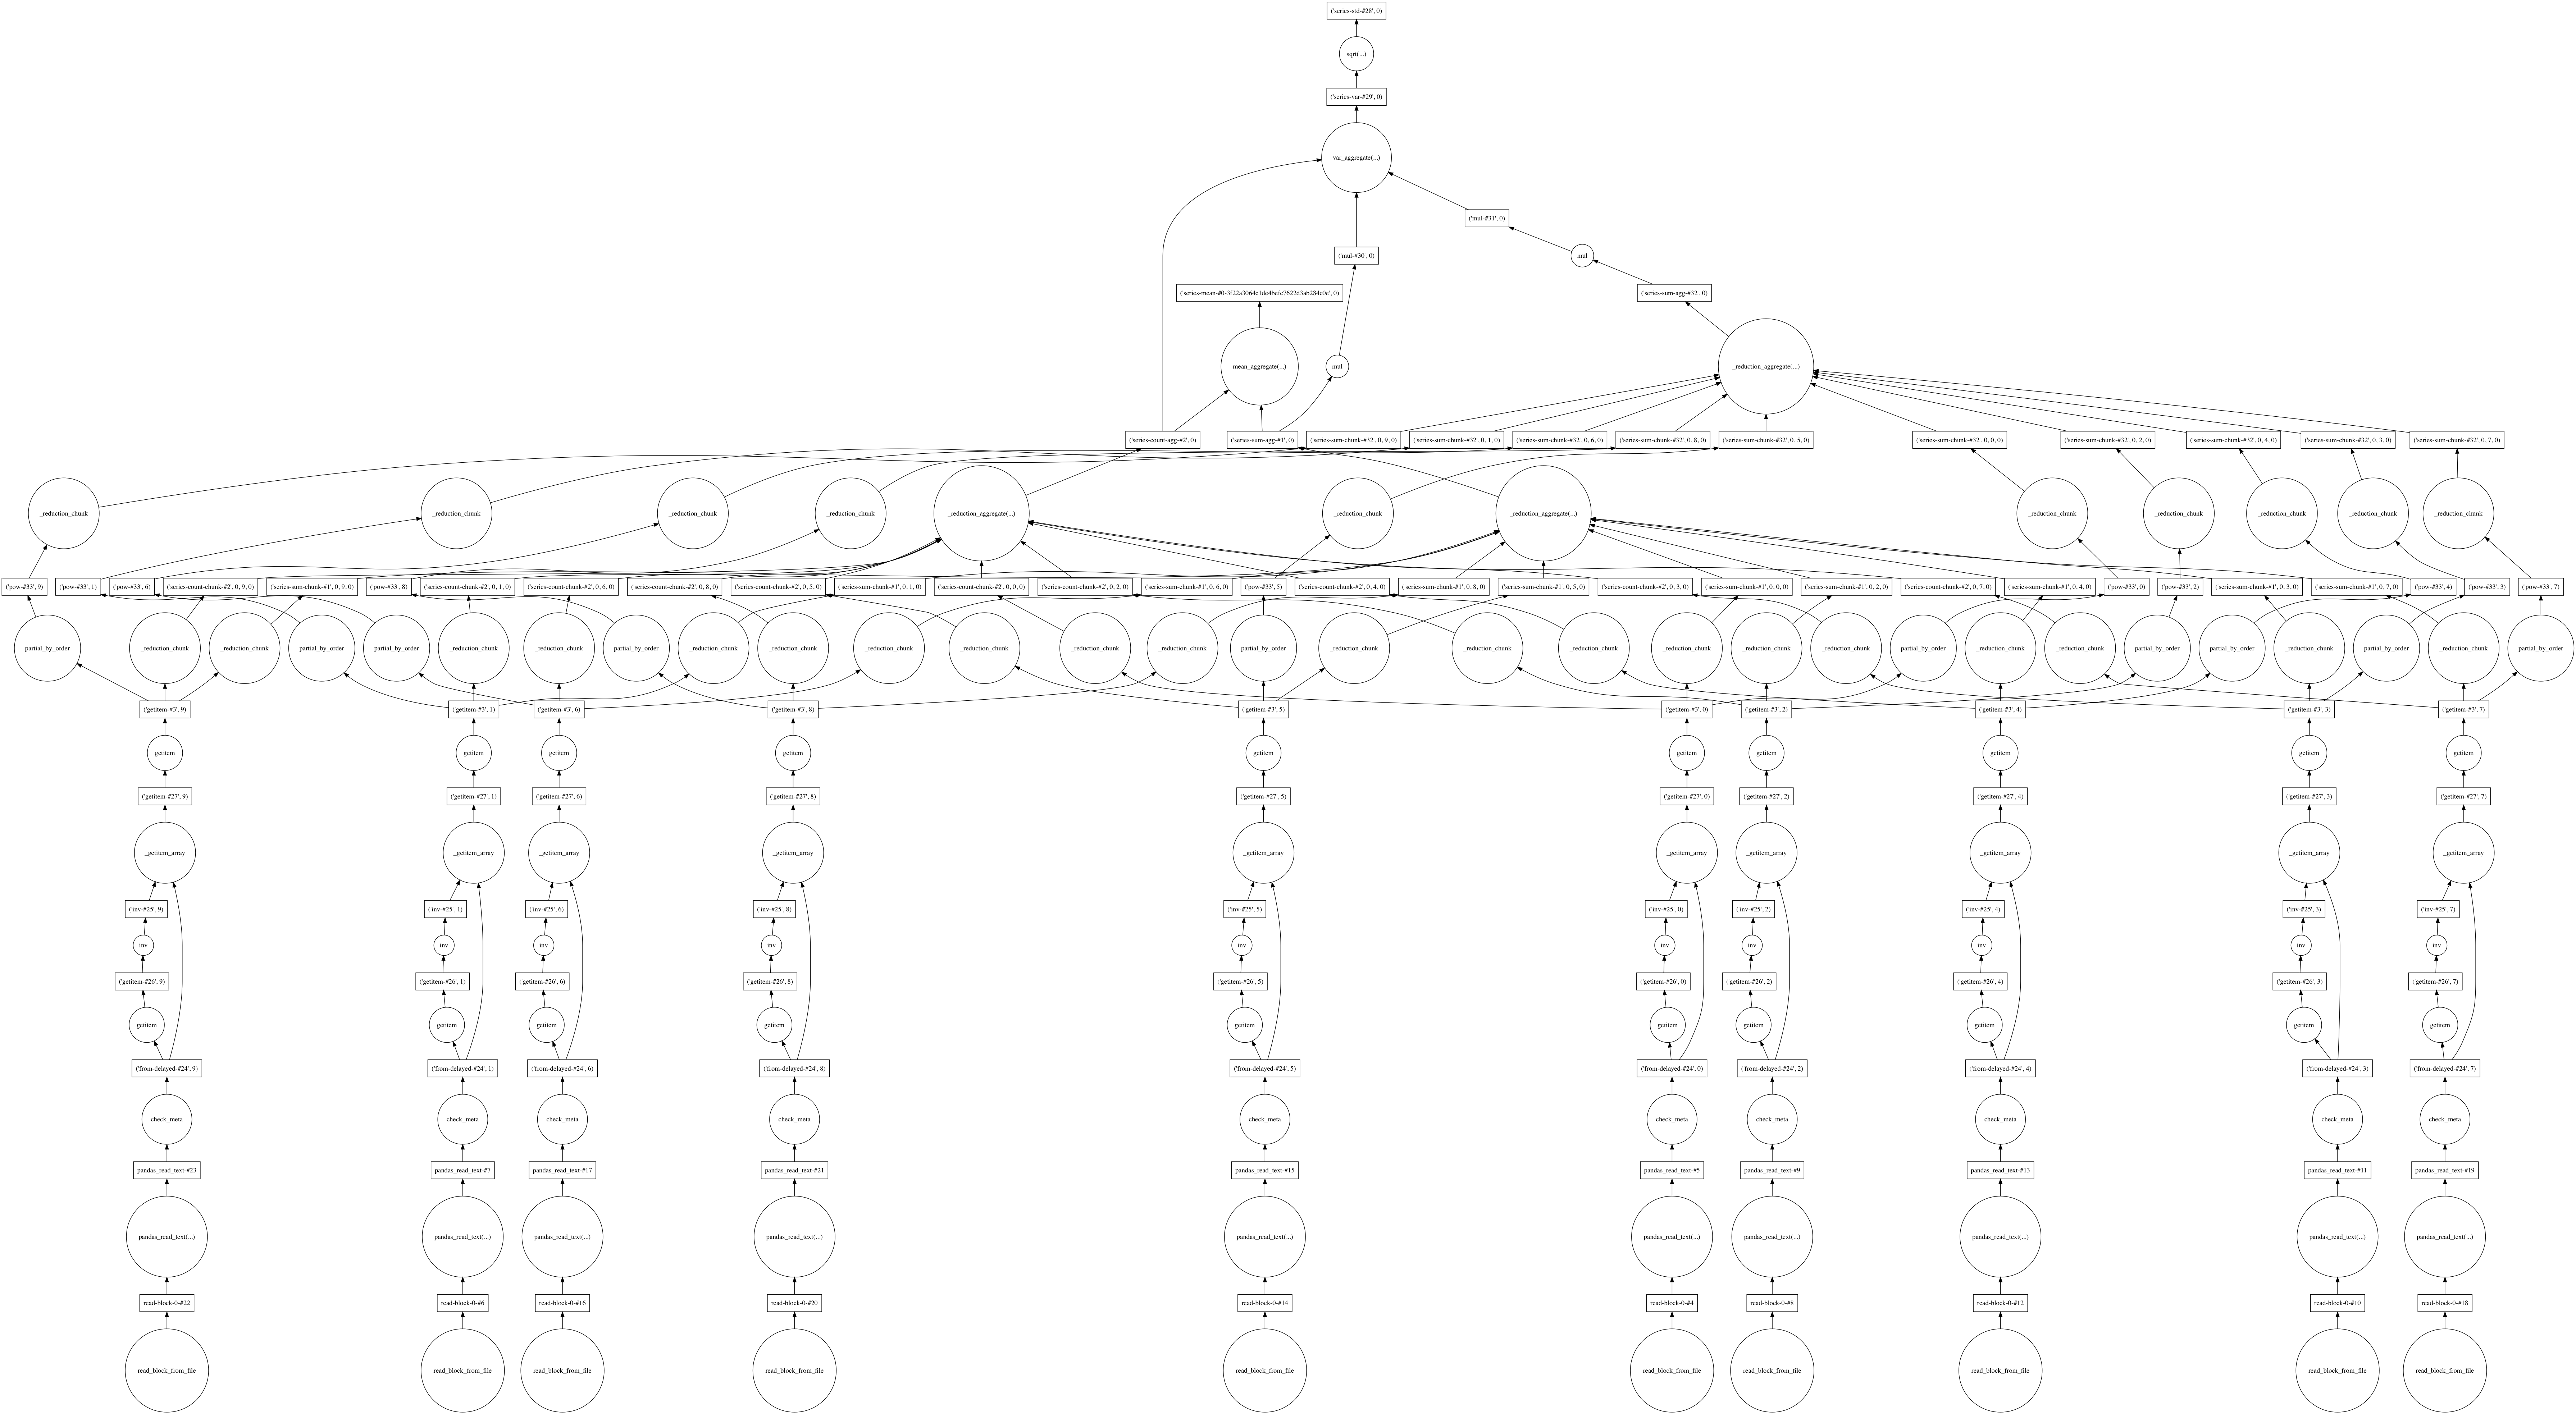

In [39]:
dask.visualize(mean_delay, std_delay)

## Converting `CRSDepTime` to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [40]:
# recreate the read_csv task with parsed dates
df = dd.read_csv(filename,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [41]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [42]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Custom code and Dask Dataframe

Unfortunately, `dask.dataframe` currently lacks the `to_timestamp` function. In general `dask.dataframe` tries hard to emulate the Pandas api (or at least the most commonly used subset of it),  but sometimes a method/function you need won't be implemented (yet), or you need to do some custom operation that there isn't a method for.

To make this easier, `dask.dataframe` provides a few methods for implementing common patterns:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timestamp` on our own:

In [43]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(func, *args, **kwargs) method of dask.dataframe.core.Series instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        Function applied to each partition.
    args, kwargs :
        Arguments and keywords to pass to the function. The partition will
        be the first argument, and these will be passed *after*.
    meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
        An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
        and column names of the output. This metadata is necessary for
        many algorithms in dask dataframe to work.  For ease of use, some
        alternative inputs are also available. Instead of a ``DataFrame``,
        a ``dict`` of ``{name: dtype}`` or iterable of ``(name, dtype)``
        can be provided. Inst

In [44]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [45]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 110 tasks

In [46]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

### Exercise

### 8.) Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [47]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta


In [48]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

In [49]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]